In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error, r2_score

In [24]:
def AIC(y_pred,y_real,x):
    mseloss=mean_squared_error(y_pred,y_real)
    x_len=y_pred.shape[0]
    n_features=x.shape[1]

    aic=2*n_features-2*np.log(mseloss)

    return aic

def BIC(y_pred,y_real,x):
    mseloss=mean_squared_error(y_pred,y_real)
    x_len=y_pred.shape[0]
    n_features=x.shape[1]

    bic=np.log(x_len)*n_features - 2*np.log(mseloss)

    return bic

In [25]:
# Step 1: Read data from CSV and rename columns
data = pd.read_csv('/content/dataset.csv')

# Rename PubchemFP columns to x1, x2, x3, ..., x881
new_column_names = ['x{}'.format(i) for i in range(1, 882)]
data.columns = new_column_names + ['pIC50']  # Assuming the last column is pIC50

# Prepare data for modeling
X = data[new_column_names]  # Features
y = data['pIC50']  # Target variable
data

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x873,x874,x875,x876,x877,x878,x879,x880,x881,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.408935
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.292430
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.251812
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.585027
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.795880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.698970
2130,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.508638
2131,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.823909
2132,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.769551


In [26]:


# Step 2: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train Random Forest model
rf_model_all = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_all.fit(X_train, y_train)

# Step 4: Evaluate Random Forest model on validation set
y_pred_rf = rf_model_all.predict(X_val)

mse_rf = mean_squared_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

aic=AIC(y_pred_rf,y_val,X_train)

print("Random Forest Model Evaluation: All Features")
print(f"MSE: {mse_rf}")
print(f"R-squared (R2): {r2_rf}")
print(f"AIC: {aic}")

Random Forest Model Evaluation: All Features
MSE: 0.8659026811508038
R-squared (R2): 0.5479493281198242
AIC: 1762.287965508317


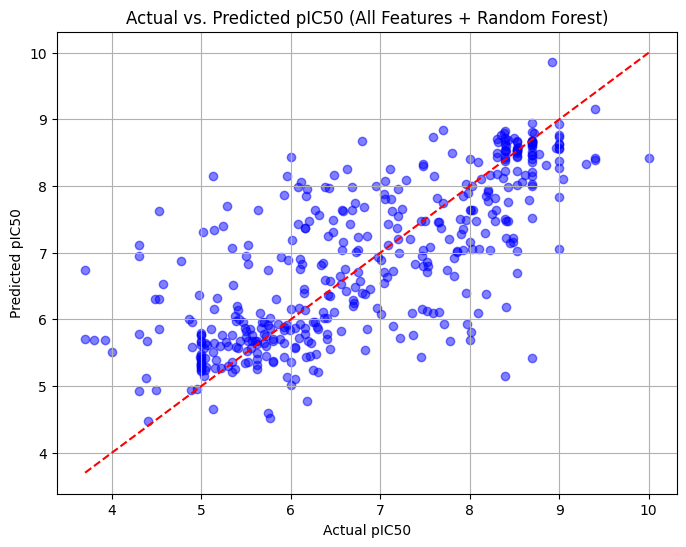

In [27]:
# Plotting predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_rf, color='blue', alpha=0.5)  # Scatter plot of actual vs. predicted values
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Actual vs. Predicted pIC50 (All Features + Random Forest)')
plt.grid(True)

plt.savefig('Actual vs. Predicted pIC50_all_features.png')
plt.show()

In [28]:
# Step 2: Remove low variance features
threshold_var = 0.2  # Define threshold for variance
selector = VarianceThreshold(threshold=threshold_var)
X_filtered = selector.fit_transform(X)

# Get selected feature indices and apply to original feature names
selected_feature_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]

# Update X with filtered features
X = pd.DataFrame(X_filtered, columns=selected_features)
X

,x17,x24,x25,x38,x146,x147,x181,x182,x194,x200,...,x759,x760,x771,x780,x798,x801,x819,x822,x823,x834
0,0,0,0,1,0,0,1,1,0,0,...,1,0,0,0,0,1,1,1,0,0
1,0,0,0,1,0,0,1,1,1,1,...,1,0,0,0,1,1,1,1,0,0
2,1,0,0,1,0,0,1,1,0,0,...,1,0,0,0,0,1,0,1,0,0
3,0,1,1,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,0,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2130,1,0,0,1,1,1,1,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2131,1,0,0,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2132,1,0,0,1,1,1,1,1,0,0,...,1,0,0,0,0,0,0,1,0,0


In [29]:
# Step 3: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
rf_model_filtered_features = RandomForestRegressor(n_estimators=100, random_state=42)  # Random Forest with 100 trees
rf_model_filtered_features.fit(X_train, y_train)

# Step 5: Evaluate Random Forest model on validation set (using selected features)
y_pred_rf_filtered_features = rf_model_filtered_features.predict(X_val)

mse_rf_filtered_features = mean_squared_error(y_val, y_pred_rf_filtered_features)
r2_rf_filtered_features = r2_score(y_val, y_pred_rf_filtered_features)
aic_1 = AIC(y_pred_rf_filtered_features, y_val, X_train)

print("Random Forest Model Evaluation (using selected features):")
print(f"MSE: {mse_rf_filtered_features}")
print(f"R-squared (R2): {r2_rf_filtered_features}")
print(f"AIC: {aic_1}")

Random Forest Model Evaluation (using selected features):
MSE: 0.8136619469072212
R-squared (R2): 0.5752219761071704
AIC: 262.4124205957595


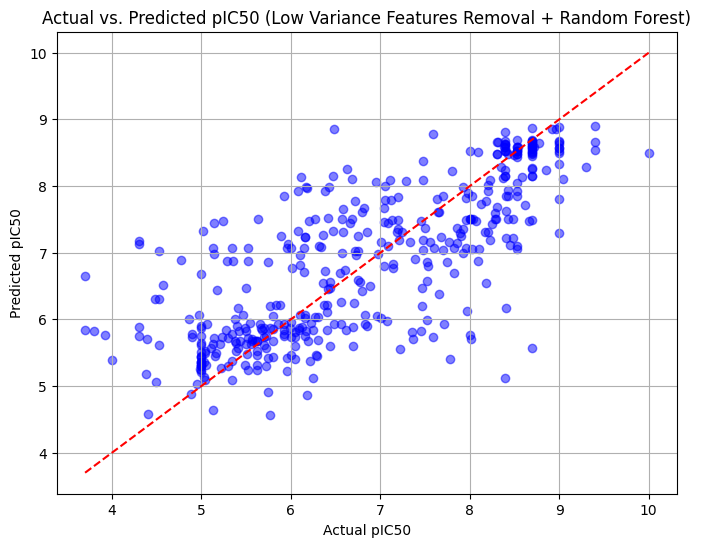

In [31]:
# Plotting predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_rf_filtered_features, color='blue', alpha=0.5)  # Scatter plot of actual vs. predicted values
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Actual vs. Predicted pIC50 (Low Variance Features Removal + Random Forest)')
plt.grid(True)

plt.savefig('Actual vs. Predicted pIC50 (Low Variance features removal_RF).png')
plt.show()

In [32]:
# Step 4: Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [33]:
# Step 5: Hyperparameter Tuning with GridSearchCV for Lasso
param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}  # Define alpha values to search over
lasso_model = Lasso(max_iter=2000, random_state=42)  # Increase max_iter for more iterations
lasso_cv = GridSearchCV(lasso_model, param_grid, cv=5)
lasso_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Lasso(max_iter=2000, random_state=42),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]})

In [34]:
# Print the best alpha parameter found by GridSearchCV
print("Best alpha:", lasso_cv.best_params_['alpha'])

Best alpha: 0.001


In [35]:
# Step 6: Feature Importance (Coefficients) with Lasso
best_lasso_model = lasso_cv.best_estimator_
lasso_coefficients = best_lasso_model.coef_

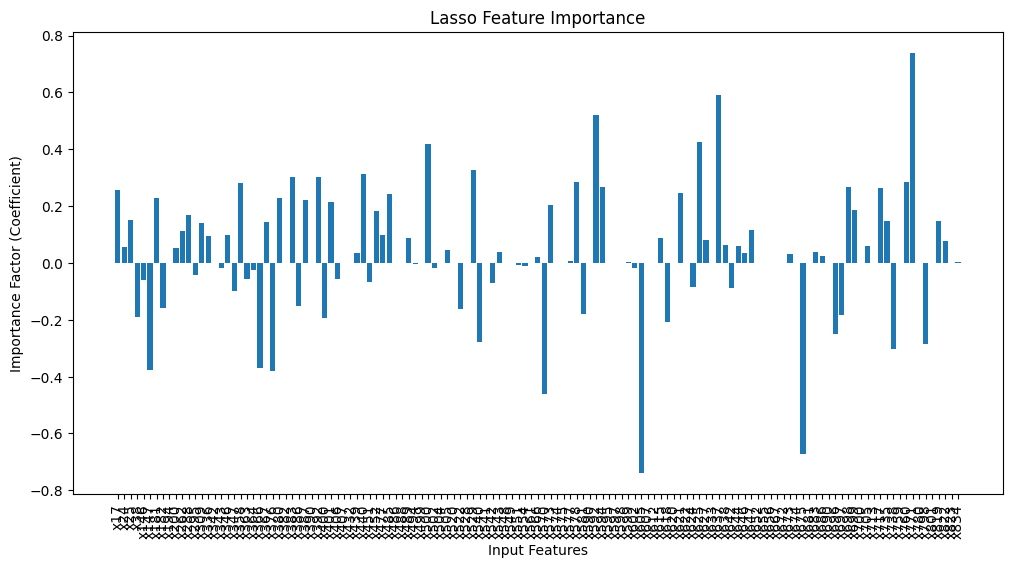

In [36]:
# Plotting feature importance (coefficients) vs. input features
plt.figure(figsize=(12, 6))
plt.bar(range(len(selected_features)), lasso_coefficients, align='center')
plt.xticks(range(len(selected_features)), selected_features, rotation=90)
plt.xlabel('Input Features')
plt.ylabel('Importance Factor (Coefficient)')
plt.title('Lasso Feature Importance')

plt.show()

In [37]:
# Step 7: Filter Features based on Coefficients
threshold_high = 0.0001  # Define threshold for high positive coefficient value (close to 1)
threshold_low = 0.0002   # Define threshold for low negative coefficient value (close to 0)

# Identify features to keep based on coefficients
selected_features_final = [feat for feat, coef in zip(selected_features, lasso_coefficients)
                           if abs(coef) >= threshold_high or (coef < 0 and abs(coef) <= threshold_low)]

print("Selected features based on coefficients:")
print(selected_features_final)
print(len(selected_features_final))

Selected features based on coefficients:
['x17', 'x24', 'x25', 'x38', 'x146', 'x147', 'x181', 'x182', 'x200', 'x262', 'x288', 'x295', 'x309', 'x336', 'x343', 'x346', 'x347', 'x358', 'x363', 'x364', 'x366', 'x367', 'x376', 'x380', 'x383', 'x386', 'x387', 'x392', 'x400', 'x401', 'x406', 'x439', 'x440', 'x451', 'x452', 'x477', 'x485', 'x489', 'x494', 'x500', 'x502', 'x505', 'x522', 'x529', 'x540', 'x542', 'x543', 'x551', 'x554', 'x566', 'x570', 'x573', 'x577', 'x578', 'x581', 'x590', 'x592', 'x594', 'x599', 'x602', 'x605', 'x615', 'x618', 'x621', 'x624', 'x625', 'x627', 'x637', 'x638', 'x642', 'x644', 'x646', 'x647', 'x673', 'x675', 'x683', 'x686', 'x696', 'x697', 'x698', 'x699', 'x705', 'x717', 'x735', 'x738', 'x760', 'x771', 'x798', 'x819', 'x822', 'x823', 'x834']
92


In [38]:
# Step 8: Train Random Forest Regression with Selected Features
X_train_final = X_train[selected_features_final]
X_val_final = X_val[selected_features_final]

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Random Forest with 100 trees
rf_model.fit(X_train_final, y_train)

RandomForestRegressor(random_state=42)

In [39]:
def AIC(y_pred,y_real,x):
    mseloss=mean_squared_error(y_pred,y_real)
    x_len=y_pred.shape[0]
    n_features=x.shape[1]

    aic=2*n_features-2*np.log(mseloss)

    return aic

def BIC(y_pred,y_real,x):
    mseloss=mean_squared_error(y_pred,y_real)
    x_len=y_pred.shape[0]
    n_features=x.shape[1]

    bic=np.log(x_len)*n_features - 2*np.log(mseloss)

    return bic

In [40]:
# Step 9: Evaluate Random Forest model on validation set
y_pred_rf = rf_model.predict(X_val_final)

mse_rf = mean_squared_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

print(f"Random Forest Model Evaluation:")
print(f"MSE: {mse_rf}")
print(f"R-squared (R2): {r2_rf}")

Random Forest Model Evaluation:
MSE: 0.8051054963904661
R-squared (R2): 0.5796889321395367


In [41]:
aic=AIC(y_pred_rf,y_val,X_train_final)
print(aic)
bic = BIC(y_pred_rf,y_val,X_train_final)
print(bic)

184.43356391746667
557.6576931345002


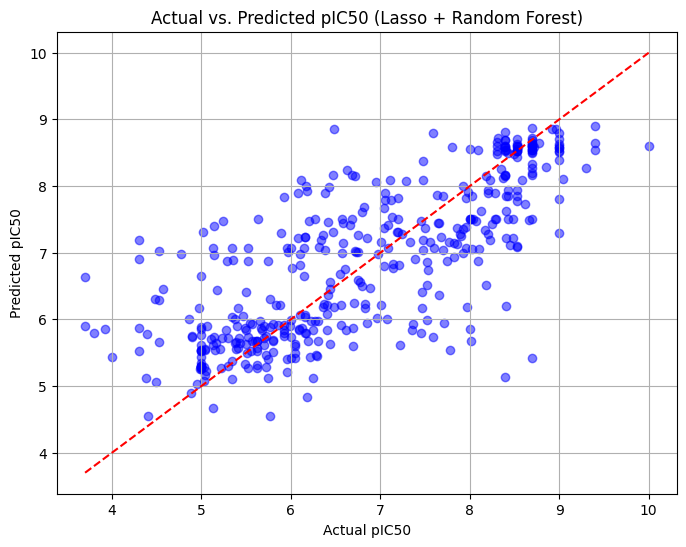

In [42]:
# Plotting predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_rf, color='blue', alpha=0.5)  # Scatter plot of actual vs. predicted values
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Actual vs. Predicted pIC50 (Lasso + Random Forest)')
plt.grid(True)

plt.savefig('Actual vs. Predicted pIC50 (Lasso_RF).png')
plt.show()